In [2]:
import numpy as np
import keras
import matplotlib.pyplot as plt
from keras import layers
import keras_tuner as kt
from sklearn.model_selection import train_test_split
import pandas as pd


2024-10-23 10:55:37.676946: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-23 10:55:37.973311: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-23 10:55:38.862673: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
#Coletando dados 

df = pd.read_excel('/home/andre/Área de Trabalho/Reconstrução da Estatística Pesqueira BR/Rio de Janeiro/Moluscos/RJ_Reconstrucao_Moluscos_2024_06_25.xlsx')
df_lula_art = pd.DataFrame(df[['Ano','Lula_art']])

dados = df_lula_art.dropna()
anos_com_dados = dados["Ano"].values
anos_para_prever = np.array([1990,1991,1992,1993,1994,2016])
todos_anos = np.concatenate((anos_para_prever, anos_com_dados))
todos_anos.sort()

pesca = dados['Lula_art'].values
dados.head()


,Ano,Lula_art
28,1978,106.0
29,1979,175.0
30,1980,335.0
31,1981,373.0
32,1982,127.0


In [4]:
#Normalização dos dados

ano_mean = np.mean(anos_com_dados)
ano_std = np.std(anos_com_dados)
anos_para_prever_norm = (anos_para_prever - ano_mean)/ano_std
anos_com_dados_norm = (anos_com_dados - ano_mean)/ano_std

pesca_mean = np.mean(pesca)
pesca_std = np.std(pesca)
pesca_norm = (pesca - pesca_mean)/pesca_std

#anos_com_dados_norm = anos_com_dados_norm.reshape((-1,1,1))
anos_para_prever_norm = anos_para_prever_norm.reshape((-1,1,1))
#pesca_norm = pesca_norm.reshape((-1,1,1))


In [9]:
#Divisão entre teste e treino
#ano_treino,ano_teste,pesca_treino,pesca_teste = train_test_split(anos_com_dados_norm,pesca_norm, test_size=0.15, shuffle=False)

In [5]:
#Função para criar sequencias de dados
def criar_seq(dadosx,dadosy,tamanho):
    x,y=[],[]
    for i in range(len(dadosx)-tamanho-1):
        x.append(dadosx[i:i+tamanho])
        y.append(dadosy[i+tamanho])
    
    return np.array(x).reshape(-1,tamanho,1),np.array(y).reshape(-1,1,1)

janela_temporal=5
x,y = criar_seq(pesca_norm,pesca_norm,janela_temporal)
print(x)

anos_com_dados_norm = anos_com_dados_norm.reshape((-1,1,1))


[[[-0.03203991]
  [ 0.68827615]
  [ 2.35857427]
  [ 2.75527008]
  [ 0.18718672]]

 [[ 0.68827615]
  [ 2.35857427]
  [ 2.75527008]
  [ 0.18718672]
  [ 0.32289844]]

 [[ 2.35857427]
  [ 2.75527008]
  [ 0.18718672]
  [ 0.32289844]
  [ 1.0432145 ]]

 [[ 2.75527008]
  [ 0.18718672]
  [ 0.32289844]
  [ 1.0432145 ]
  [ 0.69871552]]

 [[ 0.18718672]
  [ 0.32289844]
  [ 1.0432145 ]
  [ 0.69871552]
  [ 0.05147499]]

 [[ 0.32289844]
  [ 1.0432145 ]
  [ 0.69871552]
  [ 0.05147499]
  [ 0.92838151]]

 [[ 1.0432145 ]
  [ 0.69871552]
  [ 0.05147499]
  [ 0.92838151]
  [ 0.03059627]]

 [[ 0.69871552]
  [ 0.05147499]
  [ 0.92838151]
  [ 0.03059627]
  [ 0.38553462]]

 [[ 0.05147499]
  [ 0.92838151]
  [ 0.03059627]
  [ 0.38553462]
  [ 2.92751957]]

 [[ 0.92838151]
  [ 0.03059627]
  [ 0.38553462]
  [ 2.92751957]
  [-0.75757566]]

 [[ 0.03059627]
  [ 0.38553462]
  [ 2.92751957]
  [-0.75757566]
  [-0.05291864]]

 [[ 0.38553462]
  [ 2.92751957]
  [-0.75757566]
  [-0.05291864]
  [-1.00812038]]

 [[ 2.92751957]


In [14]:
#Fit do modelo e salvando seus pesos
model = keras.Sequential([
    layers.LSTM(32, return_sequences=True, activation='tanh', input_shape=(janela_temporal, 1)),
    layers.Dropout(0.1),
    
    layers.LSTM(64, return_sequences=True, activation='tanh'),  
    #layers.Dropout(k),
    
    layers.LSTM(128, return_sequences=True, activation='tanh'), 
    #layers.Dropout(k),
    
    layers.LSTM(256, return_sequences=False, activation='leaky_relu'),
    #layers.Dropout(k),
    
    layers.Dense(128, activation='leaky_relu'), 
    #layers.Dropout(k), 

    layers.Dense(32, activation='leaky_relu'),
    #layers.Dropout(k), 

    layers.Dense(1, activation='linear')
])

opt = keras.optimizers.Adam(learning_rate=0.0002)
model.compile(optimizer=opt, loss='mse')


history = model.fit(x,y, epochs=1000, verbose=1)

Epoch 1/1000


/home/andre/.local/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.7684
Epoch 2/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7663 
Epoch 3/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7528 
Epoch 4/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7521 
Epoch 5/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7519 
Epoch 6/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7556
Epoch 7/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7498 
Epoch 8/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7575 
Epoch 9/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7558
Epoch 10/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7560
Epoch 11/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7496 
Epoch 12/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7494 
Epoch 13/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7416 
Epoch 14/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7389 
Epoch 15/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7475 
Epoch 16/1000
2/2 

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Previsões dos dados ausentes: [[ 89.36331]
 [ 89.80735]
 [ 90.27321]
 [ 90.74948]
 [ 91.24627]
 [102.26819]]


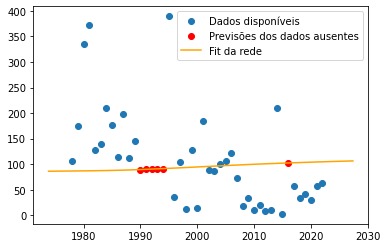

In [15]:
#Previsões
prev_disponiveis = model.predict(anos_com_dados_norm)*pesca_std + pesca_mean
prev_ausentes = model.predict(anos_para_prever_norm)*pesca_std + pesca_mean

#Colocando valores negativos para 0
for i in range(len(prev_ausentes)):
    if prev_ausentes[i]<0:
        prev_ausentes[i]=0

#Plot dos dados e previsões
f1=plt.figure(1).add_subplot()
f1.scatter(anos_com_dados,pesca,label='Dados disponíveis')
f1.scatter(anos_para_prever,prev_ausentes, color='red', label='Previsões dos dados ausentes')

#Plot do fit da rede
p = np.linspace(-2,2,50).reshape((-1,1,1))
y1 = model.predict(p)*pesca_std + pesca_mean
f1.plot(p.reshape(-1)*ano_std + ano_mean,y1.reshape(-1),color='orange',label='Fit da rede')

#Print das previsões
print('Previsões dos dados ausentes:', prev_ausentes)


plt.legend()
plt.show()

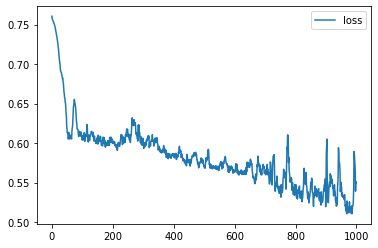

In [16]:
loss = history.history['loss']
plt.plot(loss,label='loss')
plt.legend()
plt.show()